In [1]:
%matplotlib inline

In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from graph_tool.all import *

In [94]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)
sns.set_palette('deep')
sns.set()

In [4]:
DATA = './data/'

# 1. Introduction to Patents
<img src="./data/patent_seal.png" alt="Drawing" style="width: 200px;"/>

The data used in this project is provided by the [patentsview.org](‘http://www.patentsview.org') website of the United States Patent and Trademark Office ([USPTO](‘https://www.uspto.gov/')). 

The USTPO defines a patent as a property right granted by the Government of the United States of America to an inventor "to exclude others from making, using, offering for sale, or selling the invention throughout the United States or importing the invention into the United States" for a limited time in exchange for public disclosure of the invention when the patent is granted.

On their [getting started webpage](‘https://www.uspto.gov/patents-getting-started/general-information-concerning-patents') the USTPO states, that there are three types of patents:


- Utility patents may be granted to anyone who invents or discovers any new and useful process, machine, article of manufacture, or composition of matter, or any new and useful improvement thereof;


-  Design patents may be granted to anyone who invents a new, original, and ornamental design for an article of manufacture;


-  Plant patents may be granted to anyone who invents or discovers and asexually reproduces any distinct and new variety of plant.


In this project we wish to investigate patents related to technology, which led to the decision of dropping all data concerning plant patents, leaving us, after further cleaning explained below, with a graph built of roughly 90 million edges.


There are two main stages in the process of receiving a granted patent for an invention. First a patent application needs to be filed. If the application meets the filing requirements it is awarded with a filing date and an application number. Once a filing date is assigned, the claimed invention is officially “patent pending”. In the next stage a patent examiner is assigned, who is responsible for reviewing the application. This is a lengthy process and can span multiple years. When the USTPO determines a patent application is patentable, it assigns a patent number and issues the patent. 
This is the number we use throughout this project.

In addition to patents view we also consult the [google patents database](‘https://patents.google.com/') during this project, which provides lengthier textual descriptions and original images of individual patents.

# 2. Data Sighting, Preparation and Preliminary Analysis

The USTPO provides all relevant patent data starting from 1976 to the current year in tab-separated files.<br>
For the rest of this notebook we focused our efforts on the following data sets.
 - Citations
 - General patent data
 - Categories and category mapping

## 2.1 Sighting

### Citations

The citations sheet is the core data set of our project. It provides the base of our graph and is by far the biggest file in our collection at almost 8 gigabytes. The raw file is a bit noisy and contains some less relevant columns. In detail:
 - **uuid**: Unique citation identifier chosen by PatentView for disambiguiation.
 - **patent_id**: USPTO identifier of citing patent
 - **citation_id**: USPTO identifier of cited patent
 - **date**: Grant date of cited patent
 - **name**: Filer of cited patent
 - **kind**: Type or examination status of cited patent. Details be looked up [here](http://www.patentsview.org/api/glossary.html).
 - **country**: Always US.
 - **category**: Who filed the citation (applicant or examiner).
 - **sequence**: Sequence of publication (first, second etc.).

In [7]:
pd.read_csv(DATA + 'citations_raw.tsv', delimiter='\t', nrows=5)

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
0,000007b7c0x3n9iy1othb9hz7,9009250,8127342,2012-02-01,Boynton et al.,B2,US,cited by applicant,622
1,000007obbnxmqc6v43t1c00dw,9643605,5471515,1995-11-01,Fossum et al.,A,US,cited by applicant,413
2,00000jd7thmiucpaol1hm1835,5354551,4875247,1989-10-01,Berg,NaN,US,NaN,11
3,00000oohcwply47niwhm5i42l,D786922,D718330,2014-11-01,Shin,S,US,cited by examiner,11
4,00002ghv7v87txbmryocp9i60,D490798,D190749,1961-06-01,Matri et al.,S,US,cited by examiner,1


### Patents

The patents data sheet contains general (e.g. title, date, abstract etc.) information about all granted patents starting from 1976 to 2017. The attributes are mostly congruent to the citations data frame.

In [8]:
pd.read_csv(DATA + 'patents_raw.tsv', delimiter='\t', nrows=5)

,id,type,number,country,date,abstract,title,kind,num_claims,filename
0,3930271,utility,3930271,US,1976-01-06,A golf glove is disclosed having an extra fin...,Golf glove,A,4,pftaps19760106_wk01.zip
1,3930272,utility,3930272,US,1976-01-06,A lock for a height-adjustable crib or plaype...,Crib leg lock,A,3,pftaps19760106_wk01.zip
2,3930273,utility,3930273,US,1976-01-06,A bed safety side rail arrangement which incl...,Bed safety side rail arrangement,A,24,pftaps19760106_wk01.zip
3,3930274,utility,3930274,US,1976-01-06,The assembly includes a longitudinal axis and...,Assembly for use in recreational activities,A,7,pftaps19760106_wk01.zip
4,3930275,utility,3930275,US,1976-01-06,A novel slipper and its method of fabrication...,Method of fabricating a slipper,A,9,pftaps19760106_wk01.zip


### Categories

The USPTO distinguishes 6 principal categories by which patents can be labeled. Each category is identified by an unique integer.

In [411]:
category_raw = pd.read_csv(DATA + 'categories_raw.tsv', delimiter='\t', index_col=0)
category_raw

,title
id,
1,Chemical
2,Cmp&Cmm
3,Drgs&Med
4,Elec
5,Mech
6,Others


Each category is then further divided into subcategories again labeled by an unique integer.

In [404]:
subcategory_raw = pd.read_csv(DATA + 'subcategories_raw.tsv', delimiter='\t', index_col=0)
subcategory_raw.head()

,title
id,
11,"Agriculture,Food,Textiles"
12,Coating
13,Gas
14,Organic Compounds
15,Resins


#### Category map

In [11]:
pd.read_csv(DATA + 'categorymap_raw.tsv', delimiter='\t', nrows=5)

,uuid,patent_id,category_id,subcategory_id
0,000114qfli99qqd9fsbxichy1,6243839,2,22
1,0001jsdl1xi7z84rzx9iwvdlh,4646100,2,21
2,0001qpsb0yts8daudtuf3mbm8,7712627,6,68
3,0001uc68swzzsbefc8eqhc7rg,5647223,6,69
4,0001y577lvjg6hwl6e36f46fs,5110393,1,19


## 2.2 Preprocessing 

Both the patents and citations data sheets are several gigabytes large tab-separated files and the categorymap
clocks in at about 200MB.
As a first step in the cleaning pipeline we resorted to preprocessing via the command line in order to
reduce the size of the files by extracting only the relevant columns.

More specifically, the coreutil [awk](https://www.gnu.org/software/gawk/manual/gawk.html) is a handy stream
processing language through which a tab-separated file can be read line by line, processed and written to
a new file, preferably a comma-separated one.

#### Example

```shell
echo 'Alice\tBob\tEve' | awk -F '\t' '{ print $1","$3 }' > alice_eve.csv
cat alice_eve.csv # Alice,Eve
```

In our case we extract from the above citations_raw.tsv file the patent_id and citation_id columns, from the
patents_raw.tsv the id and data columns, and from the categorymap.tsv the patent_id and subcategory_id columns.

In terms of filesize reduction we get the following improvements:
 - citations_raw.tsv **7.71GB** to **1.45GB** (~81% reduction)
 - patents_raw.tsv **4.9GB** to **121MB** (~97% reduction)
 - categorymap_raw.tsv **204.2MB** to **61.3MB** (~70% reduction)

## 2.3 Processing

### Citations

In [12]:
citations = pd.read_csv(DATA + 'citations.csv')

In [ ]:
citations.shape

(89122312, 2)

Here, the goal lies in further reducing the rows of the data. In the first step we apply the following operations:
 - Exclude all rows containing NANs.
 - Only keep rows with regular patents (number) and designs ('D' + number).
 - Only keep cited patents between 1790 ([first patent](https://www.uspto.gov/about-us/news-updates/first-us-patent-issued-today-1790)) and 2017.
 - Strip all residual whitespaces.

In [ ]:
citations.dropna(inplace=True)

citations['patent_id'] = citations.patent_id.str.strip()
citations = citations[citations.patent_id.str.match(r'([D]\d+$)|(^\d+$)')]

citations['citation_id'] = citations.citation_id.str.strip()
citations = citations[citations.citation_id.str.match(r'([D]\d+$)|(^\d+$)')]

In [ ]:
citations.shape

Since all the patent IDs are now in a valid hexadecimal format we can, to further decrease the size, map them
injectively to 32-bit integers.

**Example**
```python
int('D12', 16) = 3346
'{0:0X}'.format(3346) = 'D12'
```

In [ ]:
citations['patent_id'] = np.array(list(map(lambda i: int(i, 16), citations.patent_id)), dtype=np.int32)
citations['citation_id'] = np.array(list(map(lambda i: int(i, 16), citations.citation_id)), dtype=np.int32)

In [ ]:
citations.head()

This processed citations dataframe gets saved as a csv file, which allows us to load and work directly with the processed dataframe in the future.

In [41]:
citations.to_csv(DATA + 'citations_processed.csv', index=False)

## Patents

In [33]:
patents = pd.read_csv(DATA + 'patents.csv', dtype={'number': 'str'})

In [34]:
patents.shape

(6366670, 2)

The patents data frame is processed in a very similar way. After excluding all the NANs we again map the hexadecimal patent IDs to an 32-bit integer only keeping regular and design patents.

In [35]:
patents.dropna(inplace=True)

patents = patents[patents.number.str.match(r'([D]\d+$)|(^\d+$)')]
patents['number'] = np.array(list(map(lambda i: int(i, 16), patents.number)), dtype=np.int32)

In [36]:
patents.shape

(6322011, 2)

In [37]:
patents.head()

,number,date
0,59966065,1976-01-06
1,59966066,1976-01-06
2,59966067,1976-01-06
3,59966068,1976-01-06
4,59966069,1976-01-06


Again we save the processed data frame into a new file.

In [8]:
patents.to_csv(DATA + 'patents_processed.csv', index=False)

## Categories

In [484]:
categorymap = pd.read_csv(DATA + 'categorymap.csv', dtype={'category_id': np.int16, 'subcategory_id': np.int16})

In [485]:
categorymap.shape

(5105937, 3)

The same cleaning procedures also apply to the category map data frame. The category and subcategory dataframes are already in the correct format.

In [486]:
categorymap.dropna(inplace=True)

categorymap = categorymap[categorymap.patent_id.str.match(r'([D]\d+$)|(^\d+$)')]
categorymap['patent_id'] = np.array(list(map(lambda i: int(i, 16), categorymap.patent_id)), dtype=np.int32)

In [487]:
categorymap.shape

(5088595, 3)

Replace category and subcategory IDs with string value from category_raw and subcategory_raw.

In [488]:
categorymap = pd.merge(categorymap, category_raw.reset_index(), left_on='category_id', right_on='id', how='inner')
categorymap = pd.merge(categorymap, subcategory_raw.reset_index(), left_on='subcategory_id', right_on='id', how='inner')

categorymap = categorymap.drop(['category_id', 'subcategory_id', 'id_x', 'id_y', 'index'], axis=1)
categorymap = categorymap.rename(columns={'title_x': 'category', 'title_y': 'subcategory'})
categorymap.head()

,patent_id,category,subcategory
0,103036985,Cmp&Cmm,Computer Hardware & Software
1,127162233,Cmp&Cmm,Computer Hardware & Software
2,110466048,Cmp&Cmm,Computer Hardware & Software
3,101094949,Cmp&Cmm,Computer Hardware & Software
4,106497412,Cmp&Cmm,Computer Hardware & Software


**Note**: We have more than six million patents but only around five million of them are categorized.

In [490]:
categorymap.to_csv(DATA + 'categorymap_processed.csv', index=False)

## 3. Preliminary Statistics

In this chapter some indicator plots and numbers concerning the prepared data frames are plotted. We note a few particularities:
 - The number of patent grants has been rising constantly since the inception of the program in 1976.
 - There is no particular month or day when more or less patents are granted. (Except for the 31st day of the month since only half of the months have that many days.)
 - Most of the patent grants were filed in the category Cmp&Cmm. However, we have to note that both in the main category and subcategories a substantial amount of patents is of type other or miscellaneous.

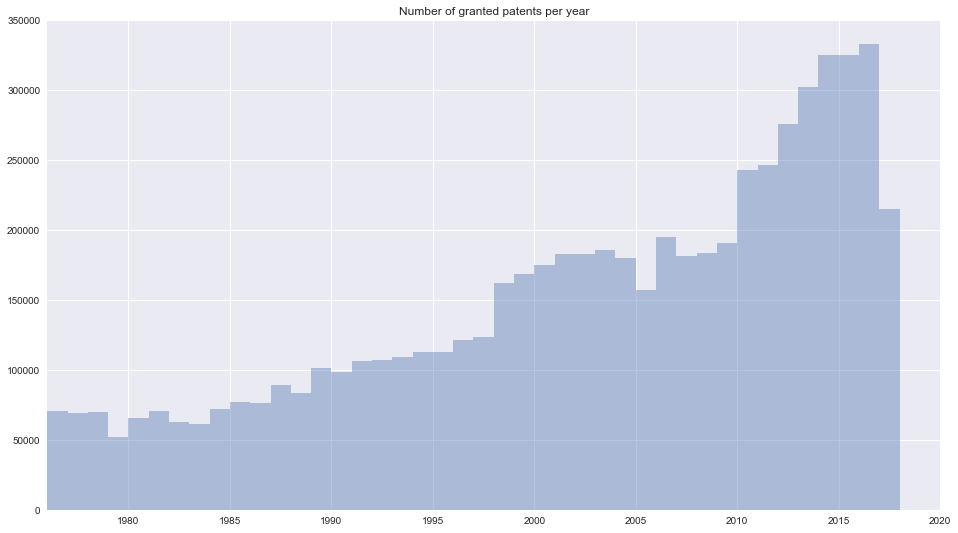

In [491]:
years = np.array(patents.date.str[:4], np.int16)

_, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_title('Number of granted patents per year')
_ = sns.distplot(years, bins=np.arange(1976, 2019, 1), ax=ax, kde=False).set(xlim=(1976, 2020))

<Container object of 31 artists>

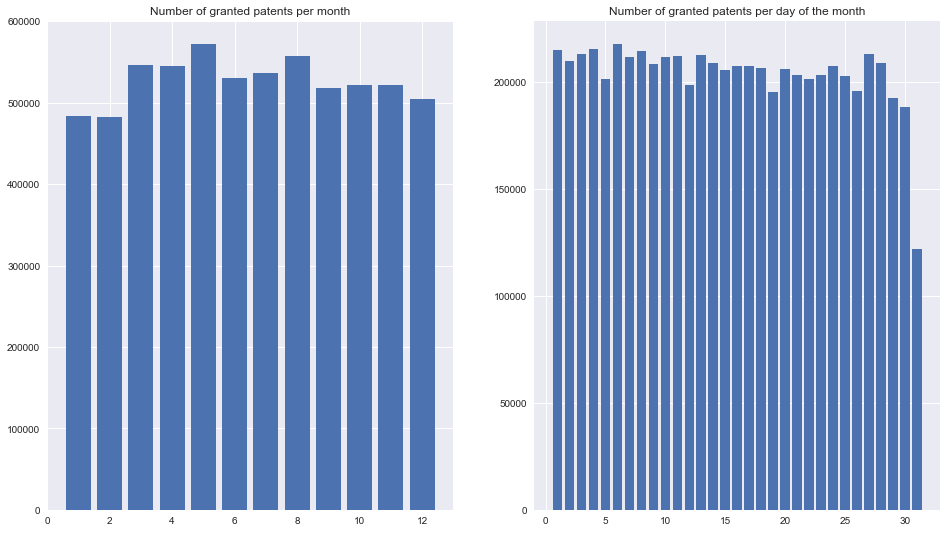

In [495]:
months = np.array(patents.date.str[5:7], np.int16)
unique, counts = np.unique(months, return_counts=True)

plt.subplot(121)
plt.title('Number of granted patents per month')
plt.bar(np.arange(1, 13, 1), counts)

days = np.array(patents.date.str[8:10], np.int16)
unique, counts = np.unique(days, return_counts=True)

plt.subplot(122)
plt.title('Number of granted patents per day of the month')
plt.bar(np.arange(1, 32, 1), counts)

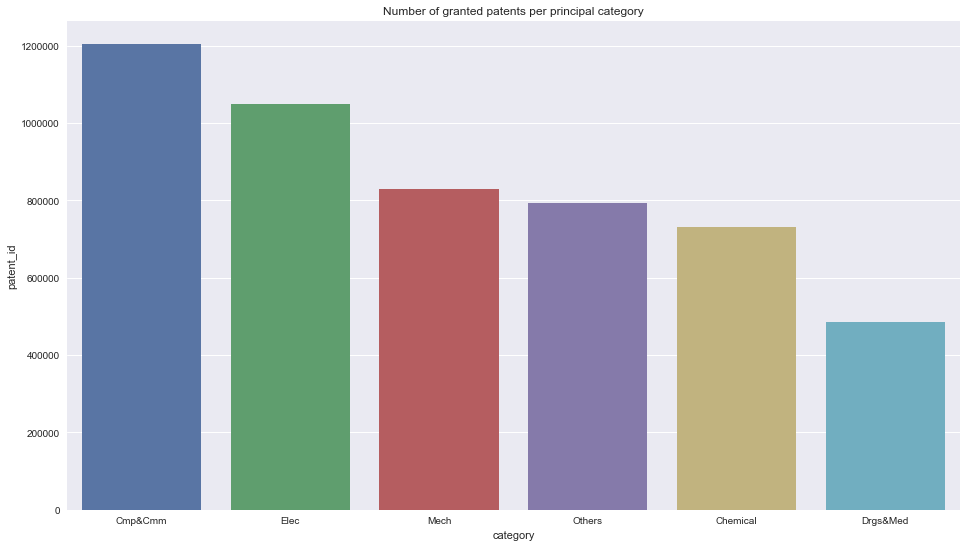

In [493]:
hist = categorymap.groupby('category').count().reset_index().sort_values('patent_id', ascending=False)

ax = plt.axes()
ax.set(ylabel=None, title='Number of granted patents per principal category')

sns.barplot(x='category', y='patent_id', data=hist, ax=ax)

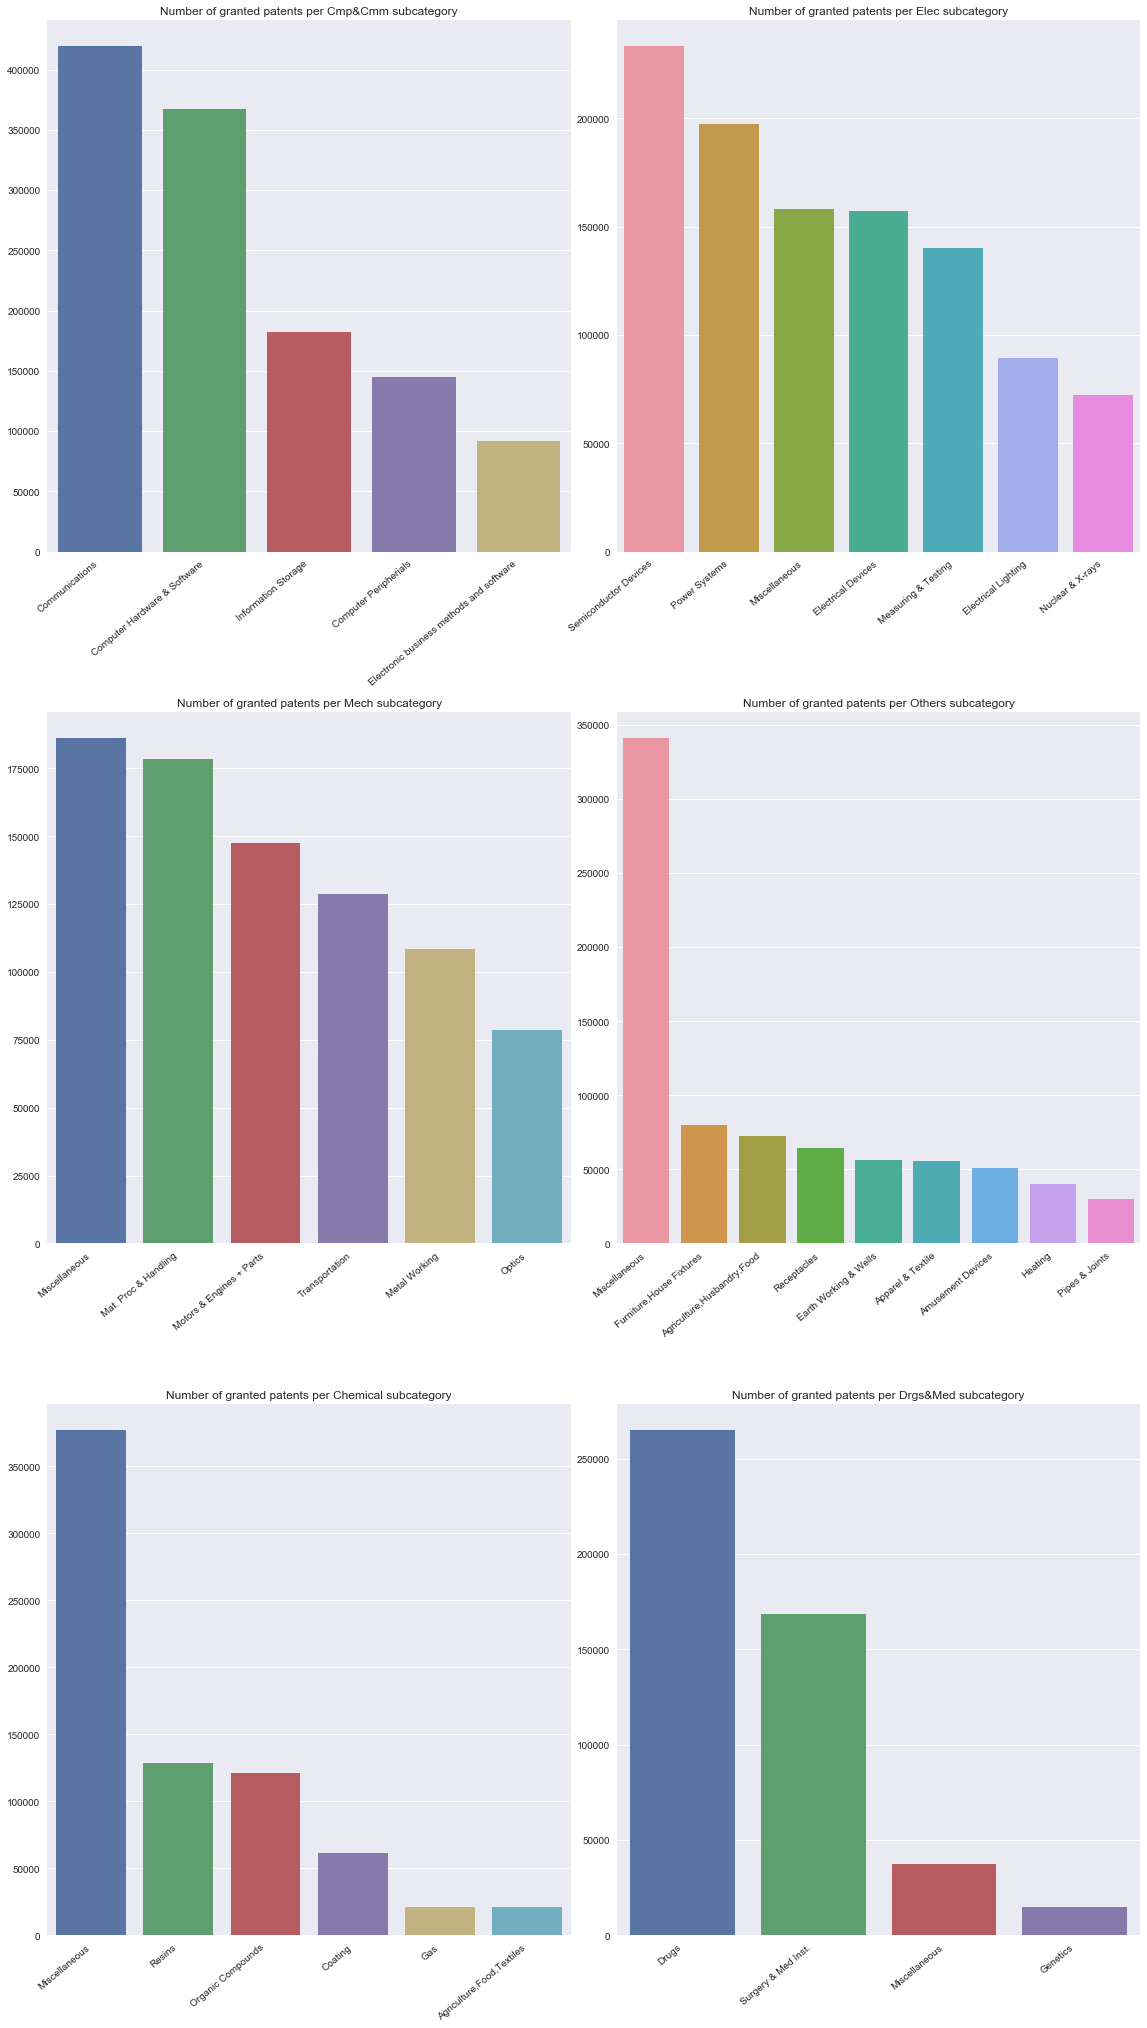

In [494]:
fig, axs = plt.subplots(3, 2, figsize=(16, 6))
fig.tight_layout()
plt.subplots_adjust(top=4.5)

plots = ['Cmp&Cmm', 'Elec', 'Mech', 'Others', 'Chemical', 'Drgs&Med']
for i in range(3):
    for j in range(2):
        hist = categorymap[categorymap.category == plots[i*2 + j]] \
            .groupby('subcategory').count() \
            .reset_index() \
            .sort_values('patent_id', ascending=False)

        sns.barplot(x='subcategory', y='patent_id', data=hist, ax=axs[i][j])
        axs[i][j].set_title('Number of granted patents per {} subcategory'.format(plots[i*2 + j]))
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
        axs[i][j].set_xticklabels(axs[i][j].get_xticklabels(), rotation=40, ha="right")

## 4. Graph software

### 4.1 What we tried

Our first library of choice was *networkx* to store, analyse and display our graphs. While trying to load the 89 million edges into a graph, we quickly noticed that *networkx* is too slow to handle such data sizes.

Looking for a graph network library that can handle many more nodes and edges, we discovered *graph-tool*. *graph-tool* stores vertices efficiently simply as an index between 0 and V-1, where V is the total number of vertices in the graph. Additional properties of the vertices (like the patent ID to identify them) can be stored alongside in a property variable. *graph-tool*'s algorithms are fast and efficient, but installing it proved to be quite challenging. 

Even though *graph-tool* is much faster than *networkx*, we are still reaching the limit of what our laptops can handle memory-wise (8GB). Therefore, if needed we will use a computer with more memory (16GB) to run more complex algorithms on the data.

### 4.2 Transforming the citations dataframe to a directed graph

In [17]:
graph = load_graph(DATA + 'citations_graph.xml.gz')

## 5. Statistics on the graph

## 6. Plans for the continuation of the project

### 6.1 Technicalities on the graph:

- First of all we want to investigate, why the graph is cyclic. Due to the linearity of time no cycles should exist. We think that it is possible, that a patent, which cites another patent which is pending, will later apparently cite into the future, if the other patent gets approved later than ones own one. This idea needs to be checked.


- Further we want to add a flag to the nodes in the graph, which shows patents, that were approved before 1976 and thus are not in the patents view data. 


- Analyze the minimum spanning tree.



### 6.2 The blog:
